# Imputation Method for Missing Median Income Values

In [ ]:
#Load the necessary libraries
import psycopg2
from psycopg2 import sql
from psycopg2.extensions import adapt, register_adapter, AsIs
from sqlalchemy import create_engine
import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


database = 'f24t03'
user = 'jsmm8'
password = getpass.getpass("Type password and hit enter: ")

#Create the connection and extract data from 'median_household_income' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=password)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the median_household_income table
query = "SELECT * FROM median_household_income;"

# Use pandas to read the SQL query into a DataFrame
try:
    df = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
df.shape

Type password and hit enter: ········
I am able to connect to the database
Data extracted successfully!


(24105, 8)

In [20]:
#Check Sample
df.head()

,geo_id,block_group,census_tract,county,state,est_inflated_past_12_months_median_income,moe_inflated_past_12_months_median_income,year
0,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,54821.0,6458.0,2018
1,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,63833.0,9867.0,2018
2,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,45833.0,5475.0,2018
3,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,30714.0,7792.0,2018
4,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,49917.0,6913.0,2018


In [21]:
#FIlter special characters if any
filtered_df = df[~df['moe_inflated_past_12_months_median_income'].isin(['**', '***'])]
filtered_df = filtered_df[filtered_df['est_inflated_past_12_months_median_income'].notnull()]
filtered_df = filtered_df[filtered_df['moe_inflated_past_12_months_median_income'].notnull()]
filtered_df = filtered_df[filtered_df['year'].isin([2020, 2021, 2022])]

In [22]:
null_income_df = filtered_df[filtered_df['est_inflated_past_12_months_median_income'].isnull() | 
                              (filtered_df['est_inflated_past_12_months_median_income'] == '')]

# Select the relevant columns
result_df = null_income_df[['geo_id', 'est_inflated_past_12_months_median_income', 'year']]

result_df.shape

(0, 3)

In [23]:
#Extract one year data
df_2022 = filtered_df[filtered_df['year']==2022]

In [24]:
# Remove rows with NA or NULL values
df_2022_cleaned = df_2022.dropna()

# Display the cleaned DataFrame
df_2022_cleaned.describe()

,moe_inflated_past_12_months_median_income,year
count,4745.000000,4745.0
mean,23900.990095,2022.0
std,16829.390674,0.0
min,460.000000,2022.0
25%,12507.000000,2022.0
50%,20020.000000,2022.0
75%,30527.000000,2022.0
max,168402.000000,2022.0


In [25]:
#check shape
df_2022_cleaned.shape

(4745, 8)

In [26]:
# Define the z-score for 90% confidence level as per census
z_score = 1.645

#Create standard error
df_2022_cleaned['standard_error_orig'] = df_2022_cleaned['moe_inflated_past_12_months_median_income'] / 1.645
#round std error
df_2022_cleaned['standard_error_orig'] = df_2022_cleaned['standard_error_orig'].round(0)
#remove character data
df_2022_cleaned['est_inflated_past_12_months_median_income'] = df_2022_cleaned['est_inflated_past_12_months_median_income'].str.replace('+', '')  # Remove plus sign
df_2022_cleaned['est_inflated_past_12_months_median_income'] = df_2022_cleaned['est_inflated_past_12_months_median_income'].str.replace('-', '')  # Remove minus sign
df_2022_cleaned['est_inflated_past_12_months_median_income'] = df_2022_cleaned['est_inflated_past_12_months_median_income'].astype(float)
#create coeff of variation
df_2022_cleaned['coefficient_of_variation'] = (df_2022_cleaned['standard_error_orig'] / df_2022_cleaned['est_inflated_past_12_months_median_income']) * 100
#round the COV value
df_2022_cleaned['coefficient_of_variation'] = df_2022_cleaned['coefficient_of_variation'].round(0)

In [27]:
#check sample
df_2022_cleaned.head()

,geo_id,block_group,census_tract,county,state,est_inflated_past_12_months_median_income,moe_inflated_past_12_months_median_income,year,standard_error_orig,coefficient_of_variation
19074,1500000US290019501001,Block Group 1,Census Tract 9501,Adair County,Missouri,80208.0,23276.0,2022,14150.0,18.0
19075,1500000US290019501002,Block Group 2,Census Tract 9501,Adair County,Missouri,64196.0,14388.0,2022,8747.0,14.0
19076,1500000US290019501003,Block Group 3,Census Tract 9501,Adair County,Missouri,52438.0,9064.0,2022,5510.0,11.0
19077,1500000US290019502001,Block Group 1,Census Tract 9502,Adair County,Missouri,46000.0,12551.0,2022,7630.0,17.0
19078,1500000US290019502002,Block Group 2,Census Tract 9502,Adair County,Missouri,64063.0,13864.0,2022,8428.0,13.0


In [28]:
#check describe stats
df_2022_cleaned.describe()

,est_inflated_past_12_months_median_income,moe_inflated_past_12_months_median_income,year,standard_error_orig,coefficient_of_variation
count,4745.000000,4745.000000,4745.0,4745.000000,4745.000000
mean,70250.503899,23900.990095,2022.0,14529.476712,21.917808
std,33930.056518,16829.390674,0.0,10230.631347,12.441193
min,6136.000000,460.000000,2022.0,280.000000,0.000000
25%,46920.000000,12507.000000,2022.0,7603.000000,13.000000
50%,63111.000000,20020.000000,2022.0,12170.000000,19.000000
75%,85917.000000,30527.000000,2022.0,18557.000000,29.000000
max,247292.000000,168402.000000,2022.0,102372.000000,61.000000


In [29]:
# Define the income limits to check the values falling under these brackets. As per census 2500- is lower income bracket values
#250000+ means upper income bracket value. As we removed + and - symbols, these values would become limits but should not be used for validating our method.

#Creating the income limits

income_lower_limit = 2500
income_upper_limit = 250000

# Filter the DataFrame based on the income conditions
filtered_df = df_2022_cleaned[(df_2022_cleaned['est_inflated_past_12_months_median_income'] > income_lower_limit) &
                               (df_2022_cleaned['est_inflated_past_12_months_median_income'] < income_upper_limit)]

# Check if there are enough records after filtering
if len(filtered_df) < 1500:
    print(f"Only {len(filtered_df)} records available for sampling.")
    sample_size = len(filtered_df)  # Adjust sample size if fewer records are available

# Set the random seed for reproducibility
random_seed = 0

# Extract a random sample of 1500 records from the filtered DataFrame
df_2022_cleaned_sample = filtered_df.sample(n=1500, random_state=random_seed)

# Display the sampled DataFrame
print("Sampled DataFrame (filtered records):")
df_2022_cleaned_sample.head()


Sampled DataFrame (filtered records):


,geo_id,block_group,census_tract,county,state,est_inflated_past_12_months_median_income,moe_inflated_past_12_months_median_income,year,standard_error_orig,coefficient_of_variation
22569,1500000US291833119041,Block Group 1,Census Tract 3119.04,St. Charles County,Missouri,93852.0,11316.0,2022,6879.0,7.0
21022,1500000US290950136133,Block Group 3,Census Tract 136.13,Jackson County,Missouri,35459.0,8383.0,2022,5096.0,14.0
20411,1500000US290770038011,Block Group 1,Census Tract 38.01,Greene County,Missouri,149063.0,98918.0,2022,60133.0,40.0
20513,1500000US290770055003,Block Group 3,Census Tract 55,Greene County,Missouri,35648.0,5486.0,2022,3335.0,9.0
22202,1500000US291650302081,Block Group 1,Census Tract 302.08,Platte County,Missouri,71827.0,52153.0,2022,31704.0,44.0


In [30]:
#Check samples describe stats
df_2022_cleaned_sample[['est_inflated_past_12_months_median_income', 'standard_error_orig', 'coefficient_of_variation']].describe()

,est_inflated_past_12_months_median_income,standard_error_orig,coefficient_of_variation
count,1500.000000,1500.000000,1500.000000
mean,71763.342667,14824.314000,21.872667
std,34213.741294,10788.404014,12.692039
min,9965.000000,746.000000,2.000000
25%,47485.750000,7787.000000,12.000000
50%,64365.000000,12293.000000,19.000000
75%,89097.250000,18801.000000,29.000000
max,247292.000000,102372.000000,61.000000


In [ ]:
#Create the connection and extract data from 'household_income' table
try:
    conn = psycopg2.connect(database=database,
                            user=user,
                            host='pgsql',
                            password=password)
    print("I am able to connect to the database")
except Exception as e:
    print("I am unable to connect to the database:", e)
    raise

# Define the query to select all data from the household_income table
query = "SELECT * FROM household_income;"

# Use pandas to read the SQL query into a DataFrame
try:
    df2 = pd.read_sql(query, conn)
    print("Data extracted successfully!")
except Exception as e:
    print("Error extracting data:", e)
finally:
    # Close the connection
    conn.close()


# Display the DataFrame
df2.shape

I am able to connect to the database
Data extracted successfully!


(24105, 40)

In [32]:


# Mapping the column names to income ranges
income_brackets = {
    'est_less_than_10k': (0, 9999),
    'est_10to15k': (10000, 14999),
    'est_15to20k': (15000, 19999),
    'est_20to25k': (20000, 24999),
    'est_25to30k': (25000, 29999),
    'est_30to35k': (30000, 34999),
    'est_35to40k': (35000, 39999),
    'est_40to45k': (40000, 44999),
    'est_45to50k': (45000, 49999),
    'est_50to60k': (50000, 59999),
    'est_60to75k': (60000, 74999),
    'est_75to100k': (75000, 99999),
    'est_100to125k': (100000, 124999),
    'est_125to150k': (125000, 149999),
    'est_150to200k': (150000, 199999),
    'est_more_than_200k': (200000, 300000)  # Settings an upper bound of 300k for estimates above 200k
}

# Initialize a list to store results
all_results = []
np.random.seed(0)
# Iterate over rows in df2
for index, row in df2.iterrows():
    # Extract the year from the row
    year = row['year']
    
    # Generate synthetic income records for each geography
    synthetic_records = []
    
    for col, (min_income, max_income) in income_brackets.items():
        num_samples = row[col]
        
        if num_samples > 0:  # Only generate samples if there are estimates
            samples = np.random.randint(
                min_income, 
                max_income + 1, 
                size=num_samples
            ) 
            synthetic_records.extend(samples)
    
    # Calculate the median for the current geography
    median_income = np.median(synthetic_records) if synthetic_records else None
    
    # Store the geography, median income, and year
    all_results.append({
        'geo_id': row['geo_id'],
        'Median Income': median_income,
        'Year': year
    })

# Create a DataFrame for all results
results_df = pd.DataFrame(all_results)

# Check for zero or null values in the 'Median Income' column
zero_values = results_df[results_df['Median Income'] == 0]
null_values = results_df[results_df['Median Income'].isnull()]

results_df['Median Income'] = results_df['Median Income'].round(0)
# Display the results DataFrame
results_df.head()


,geo_id,Median Income,Year
0,1500000US290019501001,55311.0,2018
1,1500000US290019501002,62672.0,2018
2,1500000US290019501003,46554.0,2018
3,1500000US290019502001,30320.0,2018
4,1500000US290019502002,49989.0,2018


<Figure size 1008x576 with 0 Axes>

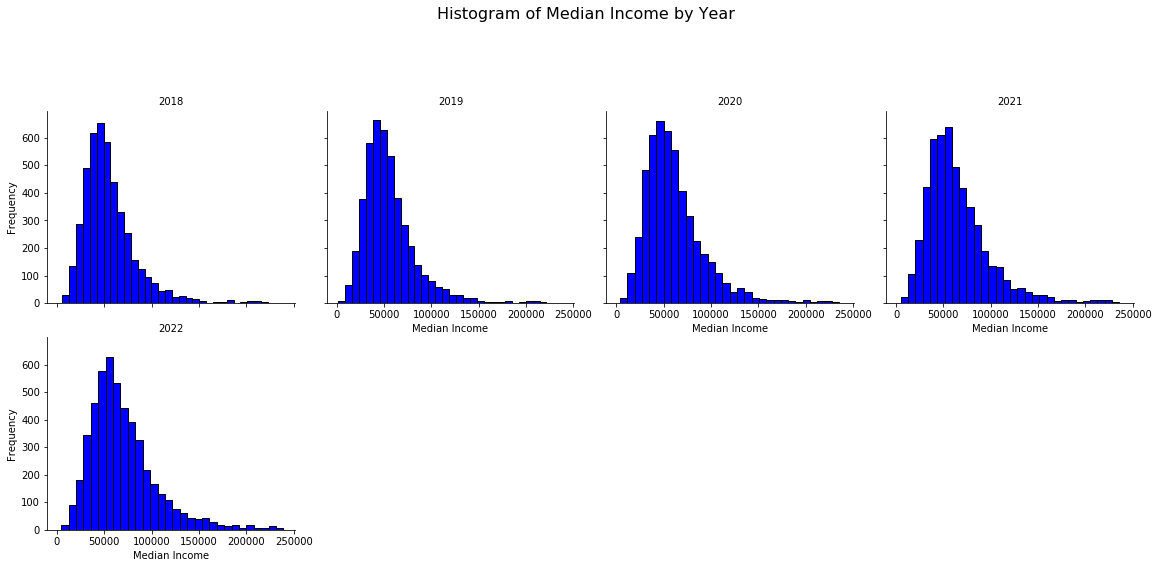

In [33]:
#Plot the data

plt.figure(figsize=(14, 8))
g = sns.FacetGrid(results_df, col='Year', col_wrap=4, height=4)
g.map(plt.hist, 'Median Income', bins=30, color='blue', edgecolor='black')

# Set titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Median Income', 'Frequency')
g.fig.suptitle('Histogram of Median Income by Year', fontsize=16)
g.fig.subplots_adjust(top=0.8)  # Adjust title to fit

plt.show()

In [34]:
#extract 2022 data
results_df_2022 = results_df[results_df['Year']==2022]

In [35]:
# Remove rows with NA or NULL values
results_df_2022_cleaned = results_df_2022.dropna()

# Display the cleaned DataFrame
results_df_2022_cleaned.describe()

,Median Income,Year
count,5009.000000,5009.0
mean,69502.732881,2022.0
std,35210.550525,0.0
min,4624.000000,2022.0
25%,45893.000000,2022.0
50%,62163.000000,2022.0
75%,84968.000000,2022.0
max,239127.000000,2022.0


In [53]:
# Extract the geo_ids from the sampled DataFrame
geo_ids_to_select = df_2022_cleaned_sample['geo_id']

# Filter the synthetic_2022_cleaned dataset to keep only the rows with these geo_ids
synthetic_2022_selected = results_df_2022_cleaned[results_df_2022_cleaned['geo_id'].isin(geo_ids_to_select)]

# Display the resulting DataFrame

synthetic_2022_selected.head()


,geo_id,Median Income,Year
19075,1500000US290019501002,63864.0,2022
19083,1500000US290019503004,10595.0,2022
19084,1500000US290019504001,34688.0,2022
19086,1500000US290019504003,50395.0,2022
19091,1500000US290019505022,63411.0,2022


In [37]:
#Check synthetic 1500 samples stats that we selected
synthetic_2022_selected.describe()

,Median Income,Year
count,1500.000000,1500.0
mean,71576.371333,2022.0
std,33683.777083,0.0
min,9964.000000,2022.0
25%,47582.000000,2022.0
50%,64156.000000,2022.0
75%,87465.750000,2022.0
max,224456.000000,2022.0


In [38]:
#check the cleaned sample stats for same 1500 sample geo_ids
df_2022_cleaned_sample[['est_inflated_past_12_months_median_income', 'standard_error_orig', 'coefficient_of_variation']].describe()

,est_inflated_past_12_months_median_income,standard_error_orig,coefficient_of_variation
count,1500.000000,1500.000000,1500.000000
mean,71763.342667,14824.314000,21.872667
std,34213.741294,10788.404014,12.692039
min,9965.000000,746.000000,2.000000
25%,47485.750000,7787.000000,12.000000
50%,64365.000000,12293.000000,19.000000
75%,89097.250000,18801.000000,29.000000
max,247292.000000,102372.000000,61.000000


In [39]:
# Perform the join on 'geo_id'
merged_df = pd.merge(
    synthetic_2022_selected,
    df_2022_cleaned_sample,
    on='geo_id',
    how='inner'  # Use 'inner' to get only matching records
)

# Filter to keep only the specified columns
filtered_columns = ['geo_id', 'Median Income', 'year','est_inflated_past_12_months_median_income' ,'moe_inflated_past_12_months_median_income','standard_error_orig','coefficient_of_variation']
result_df = merged_df[filtered_columns]
#Check sample
result_df.head()

,geo_id,Median Income,year,est_inflated_past_12_months_median_income,moe_inflated_past_12_months_median_income,standard_error_orig,coefficient_of_variation
0,1500000US290019501002,63864.0,2022,64196.0,14388.0,8747.0,14.0
1,1500000US290019503004,10595.0,2022,10608.0,4980.0,3027.0,29.0
2,1500000US290019504001,34688.0,2022,32308.0,24846.0,15104.0,47.0
3,1500000US290019504003,50395.0,2022,50536.0,20424.0,12416.0,25.0
4,1500000US290019505022,63411.0,2022,68041.0,28302.0,17205.0,25.0


In [40]:
# Define the z-score for 90% confidence level as per census
z_score = 1.645

#create COV for synthetic data
result_df['coefficient_of_variation_syn'] = (result_df['standard_error_orig'] / result_df['Median Income']) * 100

result_df['coefficient_of_variation_syn'] = result_df['coefficient_of_variation_syn'].round(0)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [41]:
#Check sample again
result_df.head()

,geo_id,Median Income,year,est_inflated_past_12_months_median_income,moe_inflated_past_12_months_median_income,standard_error_orig,coefficient_of_variation,coefficient_of_variation_syn
0,1500000US290019501002,63864.0,2022,64196.0,14388.0,8747.0,14.0,14.0
1,1500000US290019503004,10595.0,2022,10608.0,4980.0,3027.0,29.0,29.0
2,1500000US290019504001,34688.0,2022,32308.0,24846.0,15104.0,47.0,44.0
3,1500000US290019504003,50395.0,2022,50536.0,20424.0,12416.0,25.0,25.0
4,1500000US290019505022,63411.0,2022,68041.0,28302.0,17205.0,25.0,27.0


In [42]:

# create variables
CV_strategy_1 = result_df['est_inflated_past_12_months_median_income']  # Standard errors from the first strategy
CV_strategy_2 = result_df['Median Income']   # Standard errors from the second strategy

# Calculate the relative difference for each pair of standard errors
relative_difference = abs(CV_strategy_1 - CV_strategy_2) / np.maximum(CV_strategy_1, CV_strategy_2)

# Calculate similarity score for each pair
similarity_score = 1 - relative_difference

# Add the similarity score to the DataFrame
result_df['similarity_score'] = similarity_score
result_df['similarity_score'] = result_df['similarity_score'].round(2)
# Print the updated DataFrame with similarity scores
result_df[['est_inflated_past_12_months_median_income', 'Median Income', 'similarity_score']].head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,est_inflated_past_12_months_median_income,Median Income,similarity_score
0,64196.0,63864.0,0.99
1,10608.0,10595.0,1.00
2,32308.0,34688.0,0.93
3,50536.0,50395.0,1.00
4,68041.0,63411.0,0.93


In [43]:
#Check 0 values
update_data = (result_df['coefficient_of_variation'] == 0) | (result_df['coefficient_of_variation_syn'] == 0)

# Substitute similarity measure with 1 where the mask is True
result_df.loc[update_data, 'similarity_score'] = 1

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [44]:
#check stats
result_df[['est_inflated_past_12_months_median_income', 'coefficient_of_variation','coefficient_of_variation_syn','similarity_score','Median Income']].describe()

,est_inflated_past_12_months_median_income,coefficient_of_variation,coefficient_of_variation_syn,similarity_score,Median Income
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,71763.342667,21.872667,21.936000,0.966160,71576.371333
std,34213.741294,12.692039,12.761628,0.031014,33683.777083
min,9965.000000,2.000000,2.000000,0.820000,9964.000000
25%,47485.750000,12.000000,12.000000,0.950000,47582.000000
50%,64365.000000,19.000000,19.000000,0.970000,64156.000000
75%,89097.250000,29.000000,29.000000,0.990000,87465.750000
max,247292.000000,61.000000,69.000000,1.000000,224456.000000


In [45]:
#get info
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1499
Data columns (total 9 columns):
geo_id                                       1500 non-null object
Median Income                                1500 non-null float64
year                                         1500 non-null int64
est_inflated_past_12_months_median_income    1500 non-null float64
moe_inflated_past_12_months_median_income    1500 non-null float64
standard_error_orig                          1500 non-null float64
coefficient_of_variation                     1500 non-null float64
coefficient_of_variation_syn                 1500 non-null float64
similarity_score                             1500 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 117.2+ KB


In [46]:
# Compute the lower and upper bounds of the 90% confidence interval
result_df['CI_90_lower_syn'] = result_df['Median Income'] - result_df['moe_inflated_past_12_months_median_income']
result_df['CI_90_upper_syn'] = result_df['Median Income'] + result_df['moe_inflated_past_12_months_median_income']
#round up
result_df['CI_90_lower_syn'] = result_df['CI_90_lower_syn'].round(2)
result_df['CI_90_upper_syn'] = result_df['CI_90_upper_syn'].round(2)

# Display the updated dataframe with new CI columns
result_df[['geo_id', 'Median Income', 'moe_inflated_past_12_months_median_income', 'CI_90_lower_syn', 'CI_90_upper_syn']].head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,geo_id,Median Income,moe_inflated_past_12_months_median_income,CI_90_lower_syn,CI_90_upper_syn
0,1500000US290019501002,63864.0,14388.0,49476.0,78252.0
1,1500000US290019503004,10595.0,4980.0,5615.0,15575.0
2,1500000US290019504001,34688.0,24846.0,9842.0,59534.0
3,1500000US290019504003,50395.0,20424.0,29971.0,70819.0
4,1500000US290019505022,63411.0,28302.0,35109.0,91713.0


In [47]:
# Calculate the width of the confidence interval
result_df['CI_90_width_syn'] = (result_df['CI_90_upper_syn'] - result_df['CI_90_lower_syn']) / result_df['Median Income']
result_df['CI_90_width_syn'] = result_df['CI_90_width_syn'].round(2)

# Calculate the confidence index
result_df['Confidence_Index_syn'] = result_df['similarity_score'] * (1 - result_df['CI_90_width_syn'])
result_df['Confidence_Index_syn'] = result_df['Confidence_Index_syn'].round(2)

# Display the dataframe with the new Confidence Index column
result_df[['geo_id','est_inflated_past_12_months_median_income', 'Median Income', 'similarity_score', 'CI_90_lower_syn', 'CI_90_upper_syn', 'CI_90_width_syn', 'Confidence_Index_syn']].head()


,geo_id,est_inflated_past_12_months_median_income,Median Income,similarity_score,CI_90_lower_syn,CI_90_upper_syn,CI_90_width_syn,Confidence_Index_syn
0,1500000US290019501002,64196.0,63864.0,0.99,49476.0,78252.0,0.45,0.54
1,1500000US290019503004,10608.0,10595.0,1.00,5615.0,15575.0,0.94,0.06
2,1500000US290019504001,32308.0,34688.0,0.93,9842.0,59534.0,1.43,-0.40
3,1500000US290019504003,50536.0,50395.0,1.00,29971.0,70819.0,0.81,0.19
4,1500000US290019505022,68041.0,63411.0,0.93,35109.0,91713.0,0.89,0.10


In [48]:
# Compute the lower and upper bounds of the 90% confidence interval
result_df['CI_90_lower'] = result_df['est_inflated_past_12_months_median_income'] - result_df['moe_inflated_past_12_months_median_income']
result_df['CI_90_upper'] = result_df['est_inflated_past_12_months_median_income'] + result_df['moe_inflated_past_12_months_median_income']

#round values
result_df['CI_90_lower'] = result_df['CI_90_lower'].round(2)
result_df['CI_90_upper'] = result_df['CI_90_upper'].round(2)

# Calculate the width of the confidence interval
result_df['CI_90_width'] = (result_df['CI_90_upper'] - result_df['CI_90_lower']) / result_df['est_inflated_past_12_months_median_income']
result_df['CI_90_width'] = result_df['CI_90_width'].round(2)
# Calculate the confidence index
result_df['Confidence_Index'] = result_df['similarity_score'] * (1 - result_df['CI_90_width'])
result_df['Confidence_Index'] = result_df['Confidence_Index'].round(2)
# Display the dataframe with the new Confidence Index column
result_df[['geo_id','est_inflated_past_12_months_median_income', 'Median Income', 'similarity_score', 'CI_90_lower', 'CI_90_upper', 'CI_90_width', 'Confidence_Index']].head()


,geo_id,est_inflated_past_12_months_median_income,Median Income,similarity_score,CI_90_lower,CI_90_upper,CI_90_width,Confidence_Index
0,1500000US290019501002,64196.0,63864.0,0.99,49808.0,78584.0,0.45,0.54
1,1500000US290019503004,10608.0,10595.0,1.00,5628.0,15588.0,0.94,0.06
2,1500000US290019504001,32308.0,34688.0,0.93,7462.0,57154.0,1.54,-0.50
3,1500000US290019504003,50536.0,50395.0,1.00,30112.0,70960.0,0.81,0.19
4,1500000US290019505022,68041.0,63411.0,0.93,39739.0,96343.0,0.83,0.16


In [49]:
# Calculate the similarity score as the absolute difference
result_df['conf_index_final'] = 1 / (1 + (result_df['Confidence_Index_syn'] - result_df['Confidence_Index']).abs())
result_df['conf_index_final'] = result_df['conf_index_final'].round(2)
# Get the description of the similarity scores
result_df.describe()


,Median Income,year,est_inflated_past_12_months_median_income,moe_inflated_past_12_months_median_income,standard_error_orig,coefficient_of_variation,coefficient_of_variation_syn,similarity_score,CI_90_lower_syn,CI_90_upper_syn,CI_90_width_syn,Confidence_Index_syn,CI_90_lower,CI_90_upper,CI_90_width,Confidence_Index,conf_index_final
count,1500.000000,1500.0,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,71576.371333,2022.0,71763.342667,24385.992000,14824.314000,21.872667,21.936000,0.966160,47190.379333,95962.363333,0.72134,0.271613,47377.350667,96149.334667,0.719367,0.273367,0.975413
std,33683.777083,0.0,34213.741294,17746.936405,10788.404014,12.692039,12.761628,0.031014,29233.322450,45216.302803,0.41955,0.405162,29287.748675,45970.593510,0.417481,0.403484,0.030703
min,9964.000000,2022.0,9965.000000,1227.000000,746.000000,2.000000,2.000000,0.820000,-10780.000000,15481.000000,0.05000,-1.090000,60.000000,15588.000000,0.050000,-0.970000,0.780000
25%,47582.000000,2022.0,47485.750000,12809.500000,7787.000000,12.000000,12.000000,0.950000,26608.500000,64679.750000,0.41000,0.040000,26727.000000,64843.500000,0.410000,0.040000,0.970000
50%,64156.000000,2022.0,64365.000000,20222.500000,12293.000000,19.000000,19.000000,0.970000,41105.000000,86832.500000,0.62000,0.370000,41976.500000,86791.000000,0.620000,0.370000,0.990000
75%,87465.750000,2022.0,89097.250000,30928.000000,18801.000000,29.000000,29.000000,0.990000,62839.250000,117284.000000,0.96000,0.580000,63018.250000,117832.250000,0.960000,0.580000,1.000000
max,224456.000000,2022.0,247292.000000,168402.000000,102372.000000,61.000000,69.000000,1.000000,205745.000000,372150.000000,2.28000,0.940000,220994.000000,415694.000000,2.000000,0.940000,1.000000


In [50]:
# Calculate the median
median_confidence = np.median(result_df['conf_index_final'])


print(f"Median confidence Score: {median_confidence:.4f}")



Median confidence Score: 0.9900


In [51]:
# Bootstrapping for the median
num_iterations = 1000
bootstrap_medians = []
n = len(result_df['conf_index_final'])
for _ in range(num_iterations):
    sample = np.random.choice(result_df['conf_index_final'], size=n, replace=True)
    bootstrap_medians.append(np.median(sample))

# Calculate the 95% confidence interval for the median
lower_bound_median = np.percentile(bootstrap_medians, 2.5)
upper_bound_median = np.percentile(bootstrap_medians, 97.5)

print(f"Bootstrapped 95% Confidence Interval for Median confidence Score: ({lower_bound_median:.4f}, {upper_bound_median:.4f})")


Bootstrapped 95% Confidence Interval for Median confidence Score: (0.9900, 0.9900)


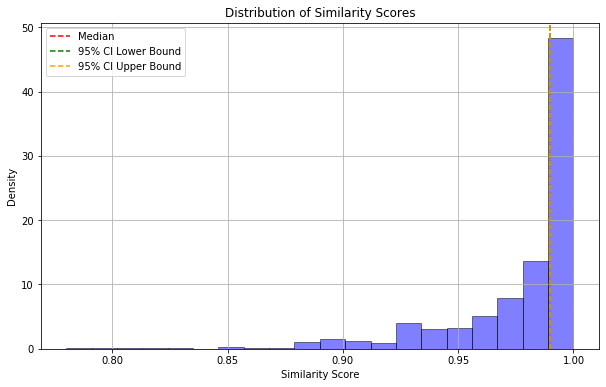

In [52]:
# Calculate the median
median_confidence = np.median(result_df['conf_index_final'])

# Calculate the interquartile range (IQR)
Q1 = np.percentile(result_df['conf_index_final'], 25)
Q3 = np.percentile(result_df['conf_index_final'], 75)
IQR = Q3 - Q1

# Bootstrapping for the median
num_iterations = 1000
bootstrap_medians = []

for _ in range(num_iterations):
    sample = np.random.choice(result_df['conf_index_final'], size=len(result_df['conf_index_final']), replace=True)
    bootstrap_medians.append(np.median(sample))

# Calculate the 95% confidence interval for the median
lower_bound_median = np.percentile(bootstrap_medians, 2.5)
upper_bound_median = np.percentile(bootstrap_medians, 97.5)

# Plotting the results
plt.figure(figsize=(10, 6))

# Histogram
plt.hist(result_df['conf_index_final'], bins=20, color='blue', alpha=0.5, edgecolor='black', density=True)


# Vertical lines for median and confidence intervals
plt.axvline(median_confidence, color='red', linestyle='--', label='Median')
plt.axvline(lower_bound_median, color='green', linestyle='--', label='95% CI Lower Bound')
plt.axvline(upper_bound_median, color='orange', linestyle='--', label='95% CI Upper Bound')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


* We see median similarity score is 0.99 and so we will use this method for imputing missing median income values.